In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

In [2]:

def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
   

## GPU 가용 상태 확인

In [3]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

## PyTorch Tensor로 데이터 로딩

In [4]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('./images/dogs-vs-cats/train/',simple_transform)
valid = ImageFolder('./images/dogs-vs-cats/valid/',simple_transform)

In [5]:
print(train.class_to_idx)
print(train.classes) 


{'cat': 0, 'dog': 1}
['cat', 'dog']


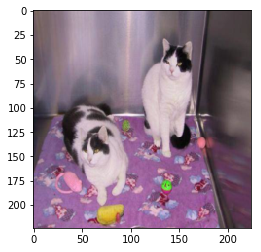

In [6]:
imshow(valid[770][0])

## 데이터 제너레이터 생성

In [7]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=16,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=16,num_workers=3,shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [9]:
model = Net()
if is_cuda:
    model.cuda()

In [10]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [11]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target, reduction='sum').data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [12]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.66 and training accuracy is 13784/23000     59.93
validation loss is  0.69 and validation accuracy is 1147/2000     57.35
training loss is   0.6 and training accuracy is 15426/23000     67.07
validation loss is  0.56 and validation accuracy is 1447/2000     72.35
training loss is  0.57 and training accuracy is 16181/23000     70.35
validation loss is  0.54 and validation accuracy is 1464/2000      73.2
training loss is  0.53 and training accuracy is 16926/23000     73.59
validation loss is  0.51 and validation accuracy is 1498/2000      74.9
training loss is  0.49 and training accuracy is 17607/23000     76.55
validation loss is   0.5 and validation accuracy is 1515/2000     75.75
training loss is  0.46 and training accuracy is 18090/23000     78.65
validation loss is  0.51 and validation accuracy is 1507/2000     75.35
training loss is  0.42 and training accuracy is 18643/23000     81.06
validation loss is  0.49 and validation accuracy is 1537/2000     76.85
traini

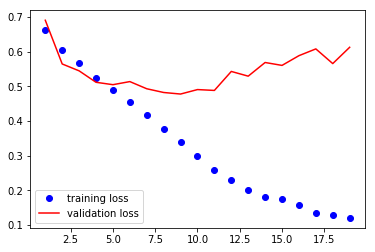

In [13]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

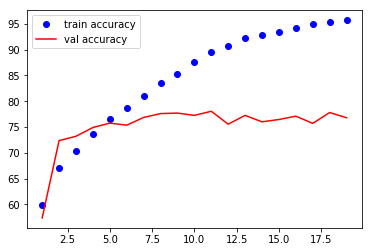

In [14]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

## VGG를 이용한 전이학습(Transfer learning)

In [5]:
torch.cuda.empty_cache()

In [6]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

### VGG 네트워크

In [10]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## 레이어 동결

In [7]:
vgg.classifier[6].out_features = 2
for param in vgg.features.parameters(): param.requires_grad = False


In [8]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [9]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target, reduction='sum').data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss.item() /len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [14]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,2):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   1.7 and training accuracy is 17803/23000      77.4
validation loss is   0.1 and validation accuracy is 1936/2000      96.8
CPU times: user 2min 48s, sys: 1min 12s, total: 4min 1s
Wall time: 4min 2s


### 드롭아웃(dropout) 적용

In [10]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [16]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.079 and training accuracy is 22436/23000     97.55
validation loss is 0.076 and validation accuracy is 1942/2000      97.1
training loss is 0.062 and training accuracy is 22549/23000     98.04
validation loss is 0.067 and validation accuracy is 1947/2000     97.35
CPU times: user 5min 37s, sys: 2min 25s, total: 8min 2s
Wall time: 8min 3s


### 데이터 증식

In [11]:
train_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(0.2)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('./images/dogs-vs-cats/train/',train_transform)
valid = ImageFolder('./images/dogs-vs-cats/train/',simple_transform)

In [12]:
train_data_loader = DataLoader(train,batch_size=16,num_workers=3,shuffle=True)
valid_data_loader = DataLoader(valid,batch_size=16,num_workers=3,shuffle=True)

In [13]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   1.7 and training accuracy is 17900/23000     77.83
validation loss is 0.098 and validation accuracy is 22374/23000     97.28
training loss is 0.084 and training accuracy is 22410/23000     97.43
validation loss is 0.064 and validation accuracy is 22549/23000     98.04
CPU times: user 9min 13s, sys: 4min 4s, total: 13min 17s
Wall time: 13min 19s


## 사전 계산된 컨볼루션 피처(Preconvoluted Feature)

In [6]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [7]:
features = vgg.features

In [8]:
for param in features.parameters(): param.requires_grad = False


In [9]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=False)

In [10]:
def preconvfeat(dataset,model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if is_cuda:
            inputs , labels = inputs.cuda(),labels.cuda()       
        inputs , labels = Variable(inputs),Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    
    return (conv_features,labels_list)

In [12]:
conv_feat_train,labels_train = preconvfeat(train_data_loader,features)

In [11]:
conv_feat_val,labels_val = preconvfeat(valid_data_loader,features)

In [13]:
class My_dataset(Dataset):
    def __init__(self,feat,labels):
        self.conv_feat = feat
        self.labels = labels
    
    def __len__(self):
        return len(self.conv_feat)
    
    def __getitem__(self,idx):
        return self.conv_feat[idx],self.labels[idx]

In [14]:
train_feat_dataset = My_dataset(conv_feat_train,labels_train)
val_feat_dataset = My_dataset(conv_feat_val,labels_val)

In [15]:
train_feat_loader = DataLoader(train_feat_dataset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dataset,batch_size=64,shuffle=True)

In [16]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [17]:
train_batches = data_gen(conv_feat_train,labels_train)
val_batches = data_gen(conv_feat_val,labels_val)

In [18]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [23]:
def fit_numpy(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target, reduction='sum').item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [24]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit_numpy(epoch,vgg.classifier,train_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit_numpy(epoch,vgg.classifier,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   5.9 and training accuracy is 6916/23000     30.07
validation loss is   1.1 and validation accuracy is 1625/2000     81.25
training loss is  0.48 and training accuracy is 20585/23000      89.5
validation loss is  0.22 and validation accuracy is 1888/2000      94.4
training loss is   0.2 and training accuracy is 21781/23000      94.7
validation loss is  0.13 and validation accuracy is 1917/2000     95.85
training loss is  0.14 and training accuracy is 22088/23000     96.03
validation loss is  0.11 and validation accuracy is 1929/2000     96.45
training loss is  0.11 and training accuracy is 22196/23000      96.5
validation loss is 0.093 and validation accuracy is 1935/2000     96.75
training loss is   0.1 and training accuracy is 22282/23000     96.88
validation loss is 0.085 and validation accuracy is 1941/2000     97.05
training loss is 0.092 and training accuracy is 22329/23000     97.08
validation loss is 0.079 and validation accuracy is 1942/2000      97.1
trainin

## 중간 CNN 레이어 시각화

In [6]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
img,label = next(iter(train_data_loader))

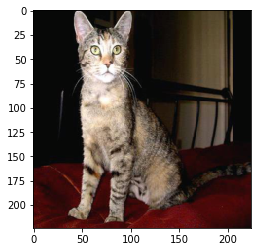

In [7]:
imshow(img[5])

In [8]:
img = img[5][None]

In [9]:
vgg = models.vgg16(pretrained=True).cuda()

In [10]:
class LayerActivations():
    features=None
    
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    
    def remove(self):
        self.hook.remove()
        

conv_out = LayerActivations(vgg.features,0)

o = vgg(Variable(img.cuda()))

conv_out.remove()

In [11]:
act = conv_out.features

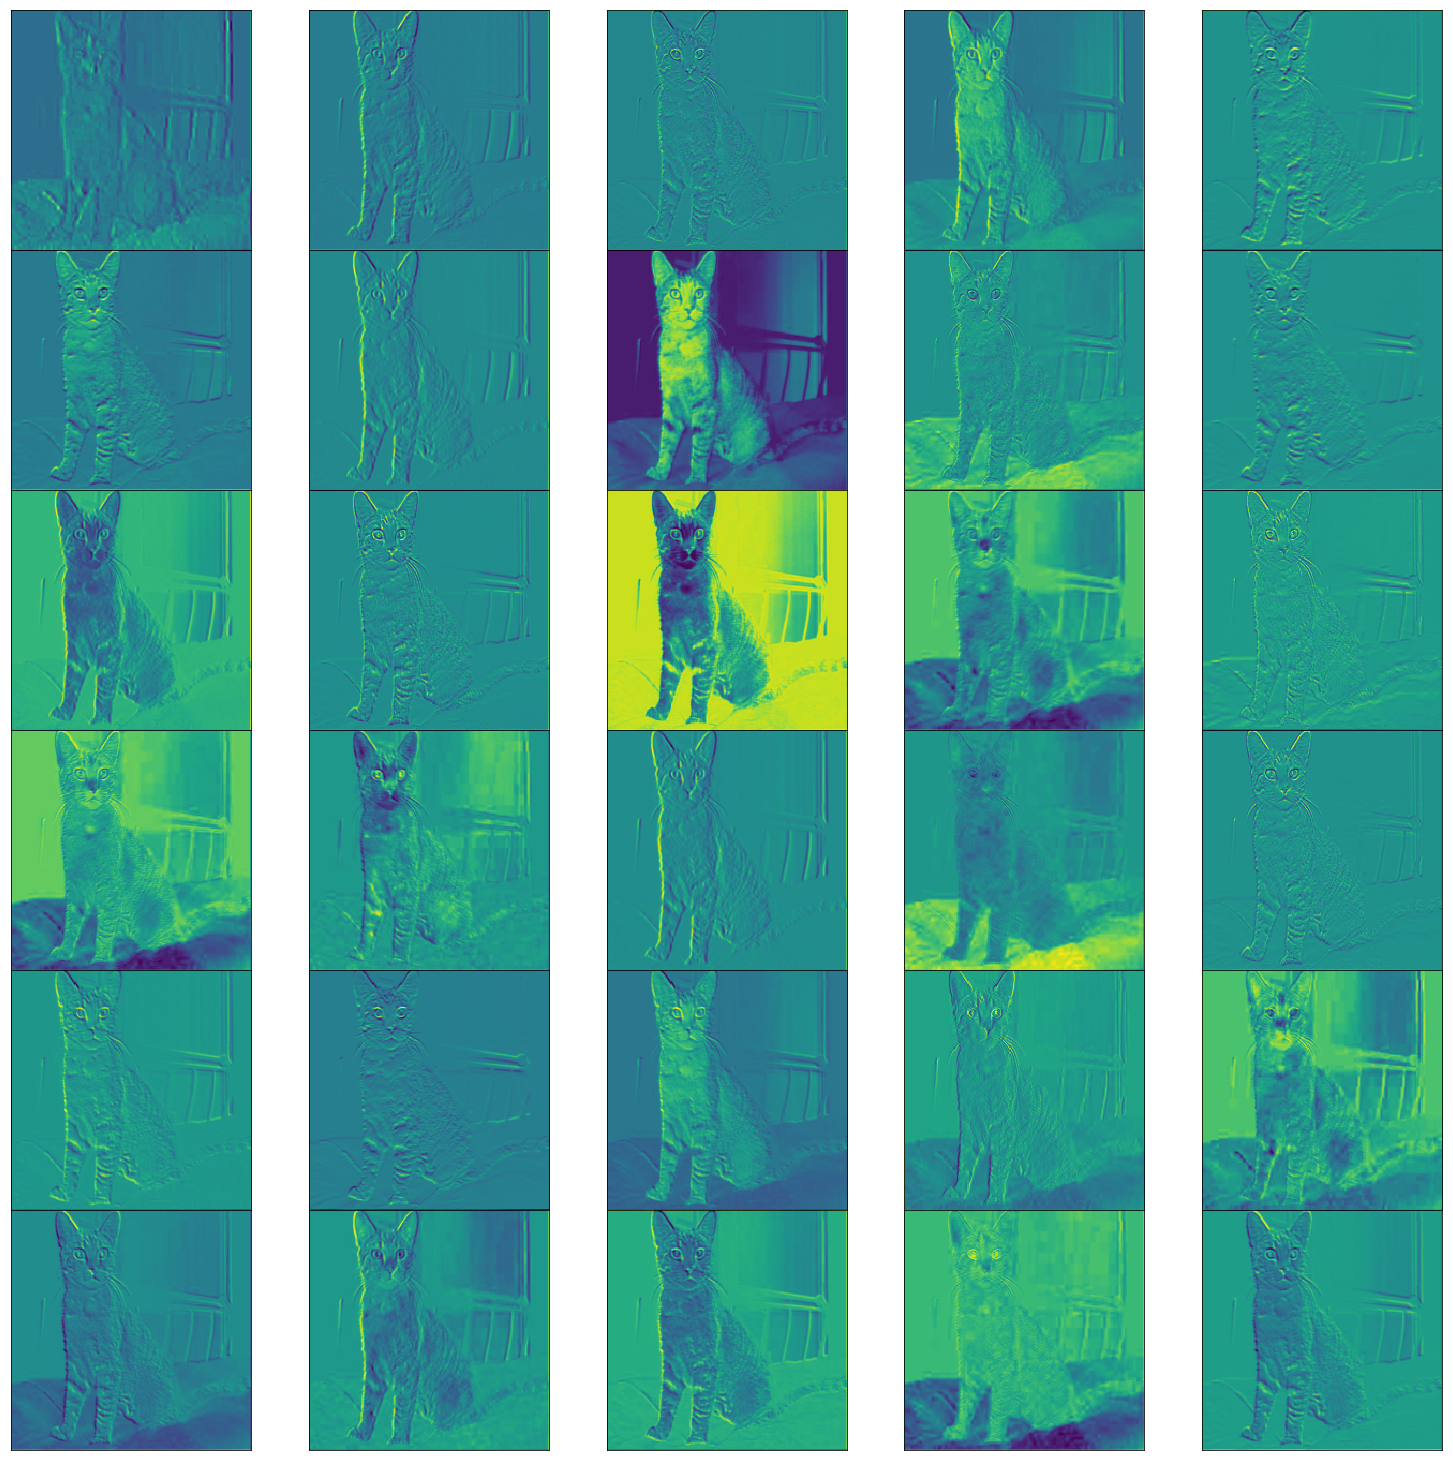

In [12]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

In [13]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

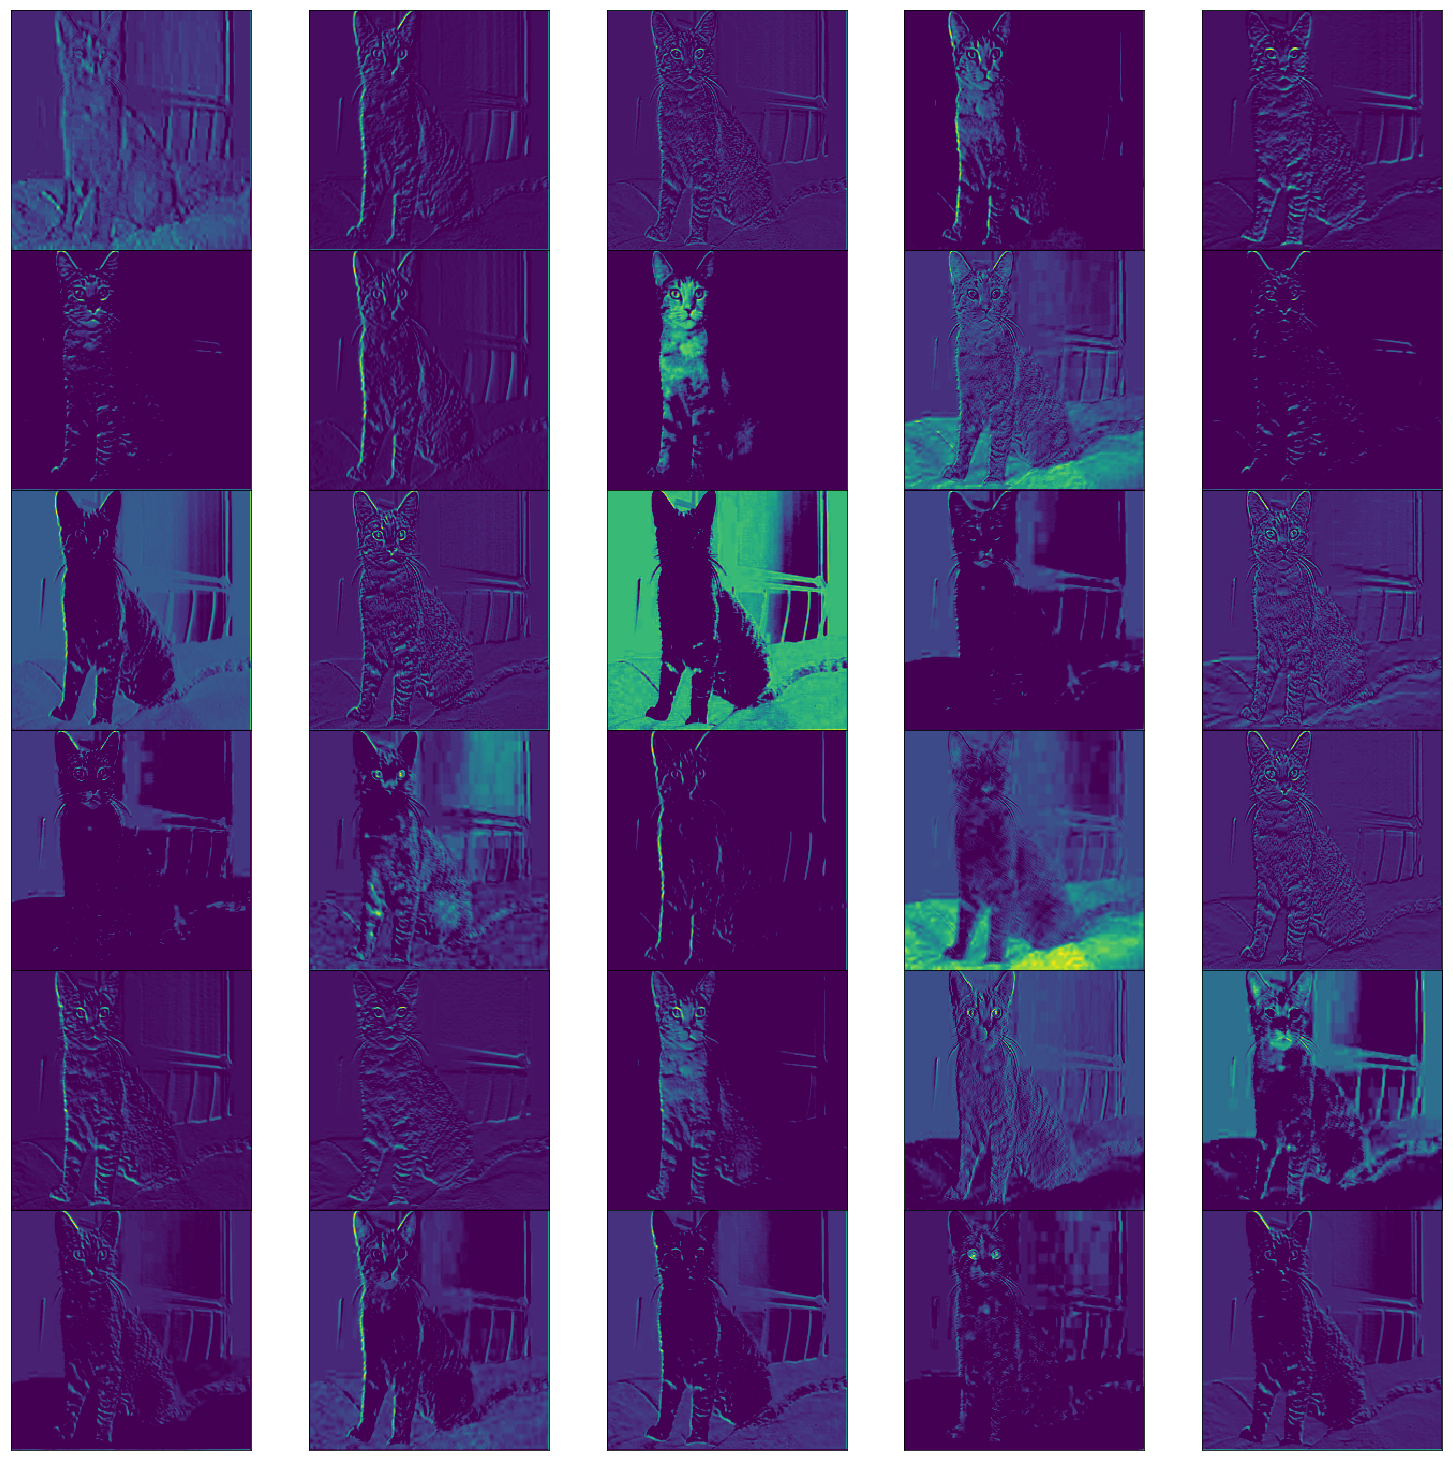

In [14]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.cuda()))

conv_out.remove()

act = conv_out.features

fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

In [15]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [16]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.cuda()))

conv_out.remove()

act = conv_out.features

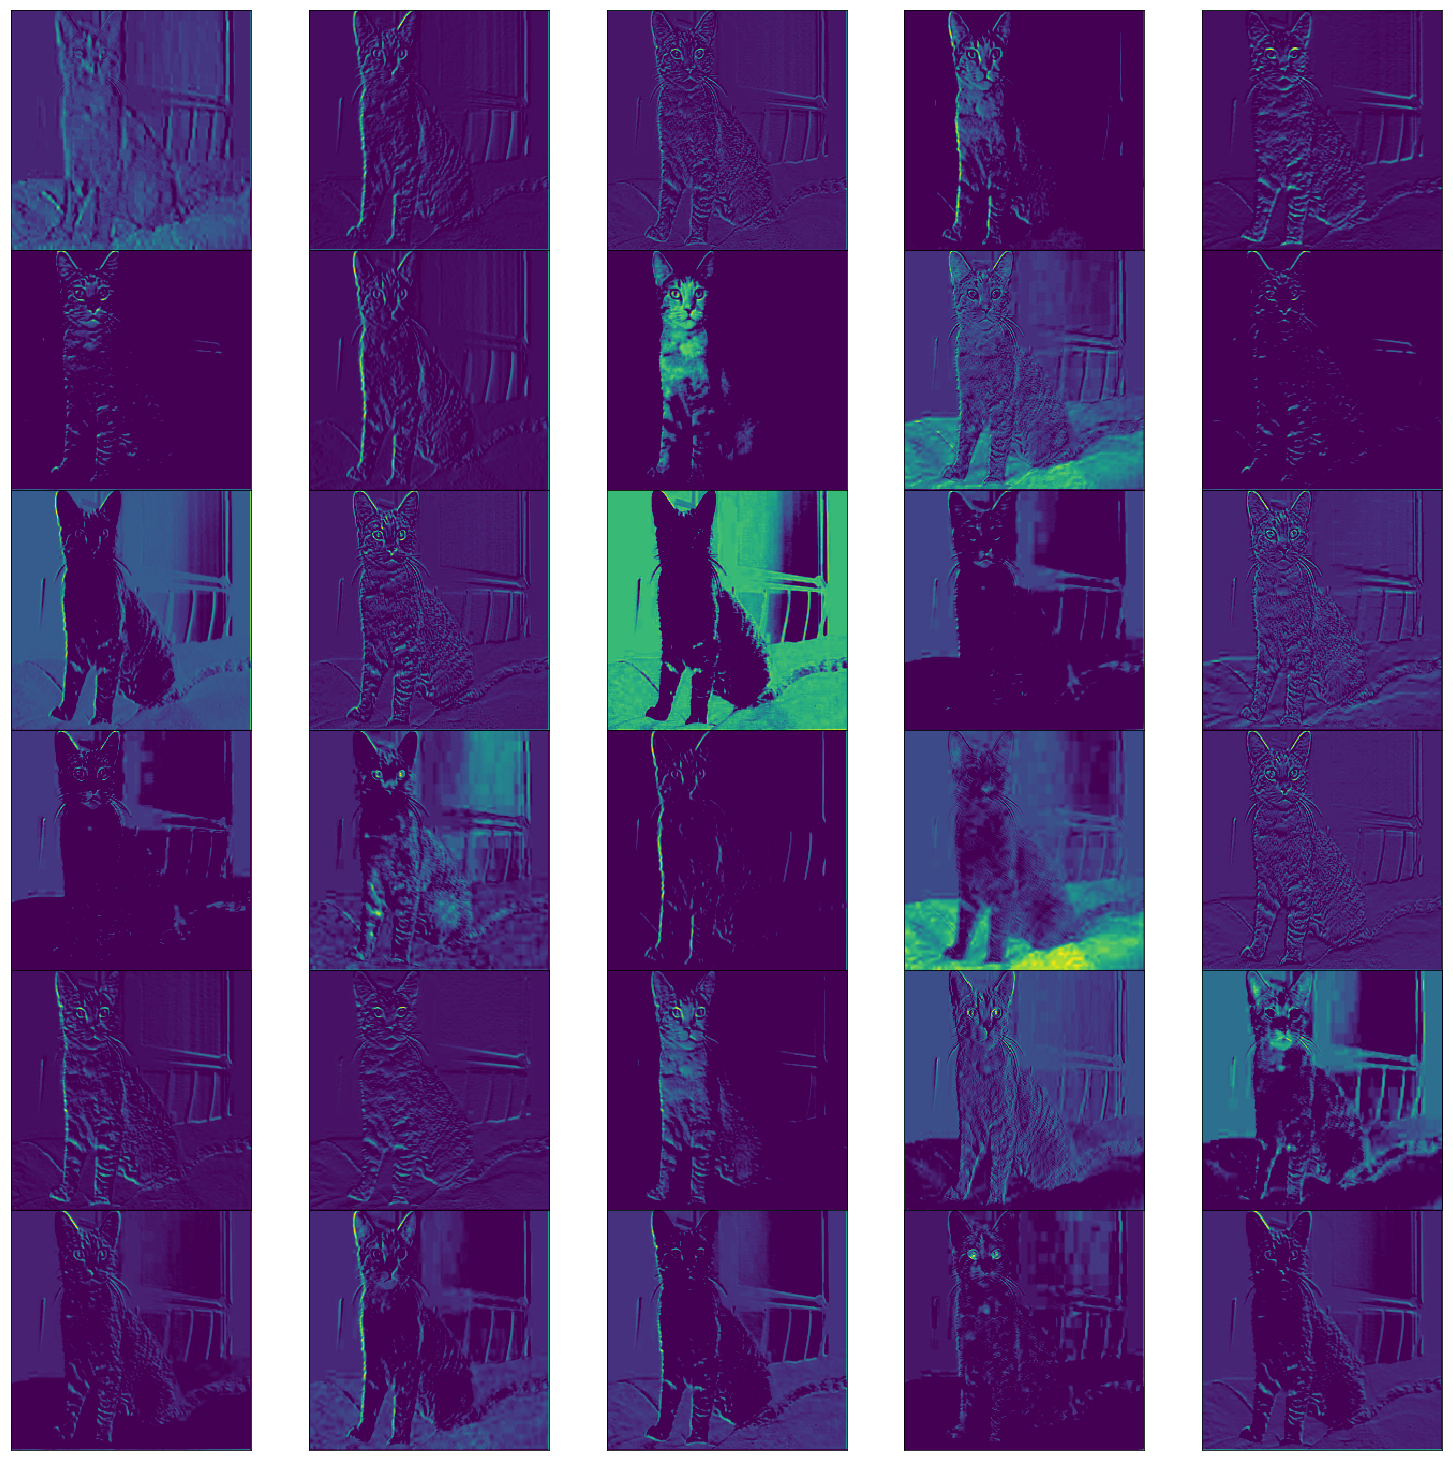

In [17]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

## 가중치 시각화

In [18]:
vgg = models.vgg16(pretrained=True).cuda()

In [19]:
vgg.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [20]:

cnn_weights = vgg.state_dict()['features.0.weight'].cpu()

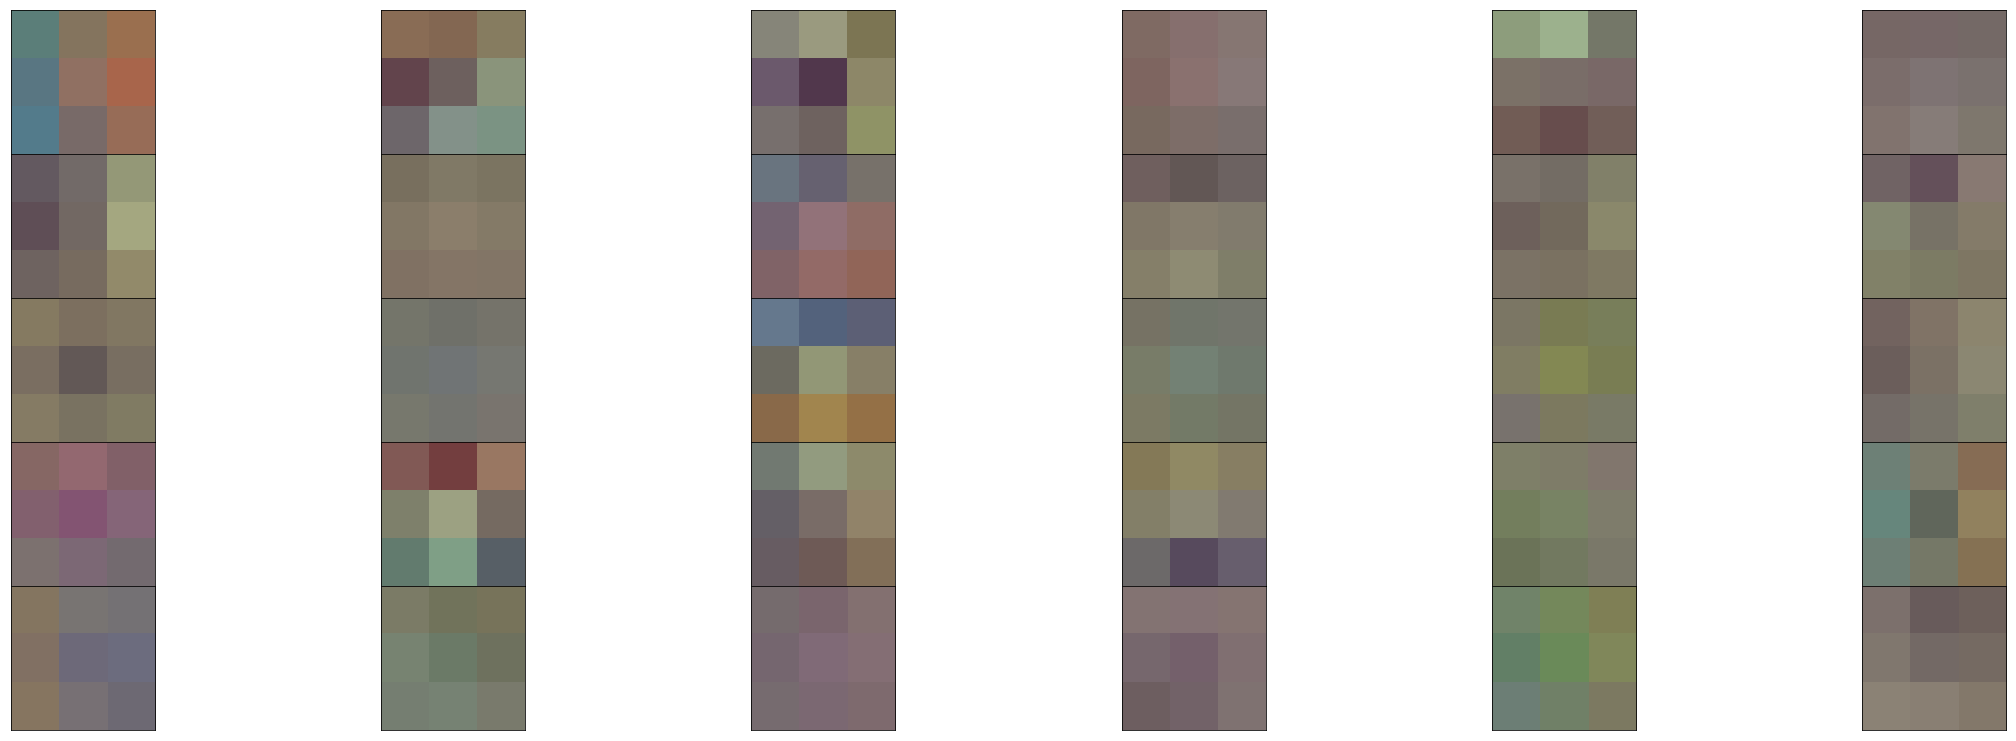

In [21]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,6,i+1,xticks=[],yticks=[])
    imshow(cnn_weights[i])

In [22]:
cnn_weights.shape

torch.Size([64, 3, 3, 3])